<h2>Урок 5<h2/>

<p>1. Попробуйте обучить нейронную сеть LSTM на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?<p/>

In [67]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import concatenate, Embedding, Input, Dense, Dropout, Bidirectional, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.utils as ku 
import numpy as np 
import pandas as pd

In [68]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
df = pd.read_csv("airline-passengers.csv")
df

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [7]:
df['Month_str'] = df['Month']

In [8]:
df['Month'] = df['Month'].str.replace('-','.').astype('float').round(2) - 1949

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    float64
 1   Passengers  144 non-null    int64  
 2   Month_str   144 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.5+ KB


In [10]:
X = df[["Month"]]
X

,Month
0,0.01
1,0.02
2,0.03
3,0.04
4,0.05
...,...
139,11.08
140,11.09
141,11.10
142,11.11


In [11]:
y = df[["Passengers"]]
y

,Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [98]:
xLen = 3
epochs = 100
batch_size = 32

In [14]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)

In [39]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5
    ),
    ModelCheckpoint(
        '../model.h5',
        save_best_only=True, 
        save_weights_only=False,
        monitor='val_loss', 
        mode='min'
    ),
]

In [30]:
dataset_train

<BatchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.int64)>

In [227]:
model = Sequential()
model.add(LSTM(256,return_sequences=True,input_shape=(xLen,1)))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 10) координат - он плотный
#model.add(Bidirectional(LSTM(50, return_sequences = True)))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(256))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
print(model.summary())


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 3, 256)            264192    
_________________________________________________________________
lstm_56 (LSTM)               (None, 3, 256)            525312    
_________________________________________________________________
lstm_57 (LSTM)               (None, 256)               525312    
_________________________________________________________________
flatten_12 (Flatten)         (None, 256)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_56 (Dense)             (None, 128)             

In [228]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import os
import datetime

In [229]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [230]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard( logdir, histogram_freq=1)

Epoch 1/100
4/4 [==============================] - 4s 382ms/step - loss: 94889.4844 - mae: 282.2213 - val_loss: 83740.3984 - val_mae: 272.3333
Epoch 2/100
4/4 [==============================] - 0s 31ms/step - loss: 94889.2266 - mae: 282.2213 - val_loss: 83740.1484 - val_mae: 272.3333
Epoch 3/100
4/4 [==============================] - 0s 32ms/step - loss: 94888.9766 - mae: 282.2213 - val_loss: 83739.9141 - val_mae: 272.3333
Epoch 4/100
4/4 [==============================] - 0s 29ms/step - loss: 94888.7578 - mae: 282.2213 - val_loss: 83739.7109 - val_mae: 272.3333
Epoch 5/100
4/4 [==============================] - 0s 30ms/step - loss: 94888.5547 - mae: 282.2213 - val_loss: 83739.5156 - val_mae: 272.3333
Epoch 6/100
4/4 [==============================] - 0s 30ms/step - loss: 94888.3750 - mae: 282.2213 - val_loss: 83739.3438 - val_mae: 272.3333
Epoch 7/100
4/4 [==============================] - 0s 31ms/step - loss: 94888.2031 - mae: 282.2213 - val_loss: 83739.1953 - val_mae: 272.3333
Epoch

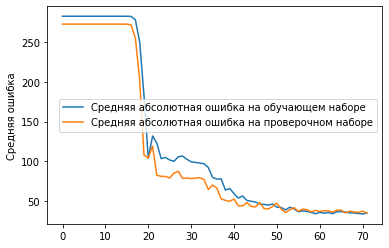

In [231]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbacks, tensorboard_callback])

hist_val = history.history['val_mae']
hist_train = history.history['mae']

plt.plot(hist_train[1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist_val[1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [232]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

In [233]:
predVal

array([402.98148, 142.94894, 274.38965, 358.54596, 215.10146, 175.50517,
       446.8631 , 245.13528, 250.45158, 133.88559, 217.35576, 273.66708,
       309.82126, 445.05753, 358.12766, 248.21188, 156.68466, 239.28552,
       425.57196, 284.85568, 139.97878, 393.7024 , 390.68268, 397.66614,
       220.0058 , 174.07776, 133.76736], dtype=float32)

In [234]:
y_test.values.flatten()[:-2]

array([359, 170, 237, 301, 237, 115, 417, 264, 302, 170, 235, 364, 271,
       391, 355, 234, 163, 229, 472, 233, 118, 337, 362, 435, 272, 191,
       119], dtype=int64)

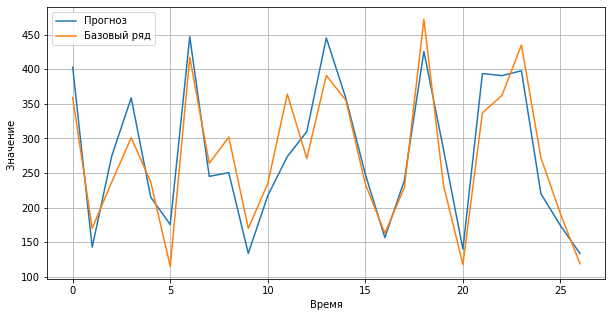

In [235]:
start = 600
step = 150
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[:], 
         label='Прогноз')
plt.plot(y_test.values.flatten()[:-2], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

In [236]:
y_test.values.flatten()[:-2]/ predVal

array([0.89085981, 1.18923579, 0.86373521, 0.83950186, 1.10180565,
       0.65525134, 0.93317171, 1.07695635, 1.20582188, 1.26974083,
       1.08117678, 1.33008323, 0.87469789, 0.87853812, 0.99126665,
       0.94274294, 1.04030604, 0.95701569, 1.10909563, 0.81795806,
       0.84298495, 0.85597651, 0.92658318, 1.09388243, 1.23633105,
       1.09721082, 0.88960413])

In [237]:
v = y_test.values.flatten()[:-2]/ predVal

In [238]:
np.mean(v)

0.9996864632764345

In [239]:
np.median(v)

0.9570156925702993

In [215]:
np.min(v)

0.6141823824976796

In [216]:
np.max(v)

1.348135751816529

<h2>Вывод<h2/>

Вполне возможно содать нейронню рекуррентную сеть с медианой 0.957 и средним 0.9997 нормального распространения ошибки

<p>2. *Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM<p/>

In [240]:
import os

In [241]:
path = ".\\LSTM"
path = os.path.realpath(path)
os.startfile(path)

<p>3. *Предложите свои варианты решения проблемы исчезающего градиента в RNN<p/>

Можно реализовать IndRNN https://arxiv.org/pdf/1803.04831.pdf

<p>Для анаконды необохдимо установить<p/>
<p>conda install m2w64-toolchain<p/>
<p>conda install libpython<p/>

In [ ]:
path = ".\\IndRNN"
path = os.path.realpath(path)
os.startfile(path)